# Sample Analysis of OKCupid Data

All this in Python 2.7.

By Jonathan Lu

3/26/2019

Updated 4/10/2019

This notebook at http://tinyurl.com/cos424-s2019-4-10

* Discuss assignment 3 expectations: https://piazza.com/class/jrjbaqaa7ql3zs?cid=254

* LDA slides

https://docs.google.com/presentation/d/1TLUlrVuotmLy5oSsfldnbNYZqyJLfgZKniyWmw1qAxQ/edit#slide=id.g57caf0041a_0_19


* What do components mean?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# increase the width of the pandas dataframe to allow scrolling through all columns

pd.options.display.max_columns = 100

In [2]:
profile_df = pd.read_csv("profiles.csv")

In [3]:
print profile_df.shape[0], ""
print profile_df.shape[1], "Columns"
profile_df.head()

59946 
31 Columns


,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


How sparse is this?

In [4]:
print "# non-null entries:", profile_df.notnull().sum().sum()
print "# Total entries: ", profile_df.shape[0] * profile_df.shape[1]

print "Proportion non-null entries: ", profile_df.notnull().sum().sum() * 1.0 / (profile_df.shape[0] * profile_df.shape[1])

# non-null entries: 1585144
# Total entries:  1858326
Proportion non-null entries:  0.852995653077


In [5]:
profile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
age            59946 non-null int64
body_type      54650 non-null object
diet           35551 non-null object
drinks         56961 non-null object
drugs          45866 non-null object
education      53318 non-null object
essay0         54461 non-null object
essay1         52375 non-null object
essay2         50308 non-null object
essay3         48470 non-null object
essay4         49409 non-null object
essay5         49099 non-null object
essay6         46175 non-null object
essay7         47496 non-null object
essay8         40732 non-null object
essay9         47344 non-null object
ethnicity      54266 non-null object
height         59943 non-null float64
income         59946 non-null int64
job            51748 non-null object
last_online    59946 non-null object
location       59946 non-null object
offspring      24385 non-null object
orientation    59946 non-null object
pets

Let's take a look at the distribution of variables in each column.

In [6]:
profile_df.describe()

,age,height,income
count,59946.000000,59943.000000,59946.000000
mean,32.340290,68.295281,20033.222534
std,9.452779,3.994803,97346.192104
min,18.000000,1.000000,-1.000000
25%,26.000000,66.000000,-1.000000
50%,30.000000,68.000000,-1.000000
75%,37.000000,71.000000,-1.000000
max,110.000000,95.000000,1000000.000000


Looks like the only numerical variables are age, height, income.

What are my columns?

See okcupid_codebook.txt for more detail.

Why are there -1s in income? They indicate "rather not say". Let's remove it for now

In [7]:
print "Before shape", profile_df.shape

profile_df = profile_df[profile_df['income'] != -1]

print "After shape", profile_df.shape

Before shape (59946, 31)
After shape (11504, 31)


Many of these are categorical data. Let's use one-hot encoding.

In [8]:
categorical_columns = ['body_type',
                      'diet',
                      'drinks',
                      'drugs',
                      'education',
                      'ethnicity',
                      'job',
                      'offspring',
                      'orientation',
                      'pets',
                      'religion',
                       'sex',
                       'sign',
                       'smokes',
                       'speaks',
                       'status']
profile_num_df = pd.get_dummies(profile_df, 
                                columns = categorical_columns)
print profile_num_df.shape
profile_num_df

(11504, 2639)


,age,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,height,income,last_online,location,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,35,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,70.0,80000,2012-06-29-21-41,"oakland, california",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,23,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,71.0,20000,2012-06-28-14-22,"berkeley, california",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,28,"i was born in wisconsin, grew up in iowa, and ...",i'm currently the youngest member on an intern...,i'm really good at a little bit of everything....,"the way i dress. some days it's hats, other da...",books = yes. avid reader.<br />\nmoves = etern...,"guitar - even if i don't play it all the

In [9]:
# Get the columns that are only numerical

print np.unique(profile_num_df.dtypes)


[dtype('uint8') dtype('int64') dtype('float64') dtype('O')]


In [10]:

print "Original augmented columns: ", profile_num_df.shape[1]


sub_columns = [c for c in profile_num_df.columns.values if 
              (profile_num_df[c].dtype == np.uint8) or 
               (profile_num_df[c].dtype == np.int64) or
               (profile_num_df[c].dtype == np.float64)]

profile_num_df = profile_num_df[sub_columns]
print "Subset to only numerical columns: ", profile_num_df.shape[1]

profile_num_df

Original augmented columns:  2639
Subset to only numerical columns:  2627


,age,height,income,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,drugs_never,drugs_often,drugs_sometimes,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,35,70.0,80000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,23,71.0,20000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,28,72.0,40000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13,30,66.0,30000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,29,62.0,50000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
43,40,71.0,60000,0,0

# Some basic analysis

In [11]:
print "Relationship statuses:"
print np.unique(profile_df['status'].values)

print profile_df['status'].describe()
print profile_df['status'].value_counts()


Relationship statuses:
['available' 'married' 'seeing someone' 'single' 'unknown']
count      11504
unique         5
top       single
freq       10465
Name: status, dtype: object
single            10465
seeing someone      483
available           468
married              86
unknown               2
Name: status, dtype: int64


If you didn't want to type into latex:

In [12]:
print profile_df['status'].value_counts().to_latex()

\begin{tabular}{lr}
\toprule
{} &  status \\
\midrule
single         &   10465 \\
seeing someone &     483 \\
available      &     468 \\
married        &      86 \\
unknown        &       2 \\
\bottomrule
\end{tabular}



In [13]:
# Let's figure out how many folks of each type there are

profile_df.groupby('status').count()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks
status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
available,468,427,279,465,388,440,435,420,422,403,408,406,398,389,369,413,427,468,468,455,468,468,233,468,375,388,468,409,452,467
married,86,75,48,86,72,84,76,71,64,62,66,63,61,62,59,60,76,86,86,83,86,86,47,86,69,78,86,81,84,86
seeing someone,483,427,260,478,409,453,458,449,440,433,425,429,418,422,394,429,447,483,483,475,483,483,169,483,408,407,483,445,468,483
single,10465,10008,6877,10246,8821,9804,9630,9343,9054,8788,8704,8659,8325,8598,7601,8588,9833,10465,10465,10149,10465,10465,5162,10465,7864,8144,10465,9199,9967,10461
unknown,2,1,1,2,2,2,2,1,2,1,1,2,1,1,1,2,1,2,2,1,2,2,1,2,1,2,2,2,2,2


Let's just deal with the 1s and 0s.

In [14]:
profile_categorical_df = profile_num_df.drop(['age', 'height', 'income'], axis=1)

In [15]:
profile_categorical_df

,body_type_a little extra,body_type_athletic,body_type_average,body_type_curvy,body_type_fit,body_type_full figured,body_type_jacked,body_type_overweight,body_type_rather not say,body_type_skinny,body_type_thin,body_type_used up,diet_anything,diet_halal,diet_kosher,diet_mostly anything,diet_mostly halal,diet_mostly kosher,diet_mostly other,diet_mostly vegan,diet_mostly vegetarian,diet_other,diet_strictly anything,diet_strictly halal,diet_strictly kosher,diet_strictly other,diet_strictly vegan,diet_strictly vegetarian,diet_vegan,diet_vegetarian,drinks_desperately,drinks_not at all,drinks_often,drinks_rarely,drinks_socially,drinks_very often,drugs_never,drugs_often,drugs_sometimes,education_college/university,education_dropped out of college/university,education_dropped out of high school,education_dropped out of law school,education_dropped out of masters program,education_dropped out of med school,education_dropped out of ph.d program,education_dropped out of space camp,education_dropped out of two-year college,education_graduated from college/university,education_graduated from high school,...,"speaks_english, spanish (poorly), russian (okay)","speaks_english, spanish (poorly), sign language (poorly)","speaks_english, spanish (poorly), tagalog (fluently)","speaks_english, spanish, arabic","speaks_english, spanish, c++","speaks_english, spanish, czech","speaks_english, spanish, estonian","speaks_english, spanish, french","speaks_english, spanish, french, russian","speaks_english, spanish, german","speaks_english, spanish, german, french, polish","speaks_english, spanish, irish","speaks_english, spanish, italian","speaks_english, spanish, italian (poorly)","speaks_english, spanish, latin, french","speaks_english, spanish, other","speaks_english, spanish, portuguese (poorly)","speaks_english, spanish, portuguese, french (okay)","speaks_english, spanish, portuguese, italian","speaks_english, spanish, sign language","speaks_english, spanish, tagalog","speaks_english, spanish, yiddish, c++, farsi","speaks_english, swahili (poorly)","speaks_english, swedish (fluently)","speaks_english, swedish (poorly)","speaks_english, tagalog","speaks_english, tagalog (fluently)","speaks_english, tagalog (fluently), german, spanish","speaks_english, tagalog (okay)","speaks_english, tagalog (okay), spanish (poorly)","speaks_english, tagalog (poorly)","speaks_english, tagalog, chinese","speaks_english, tagalog, spanish","speaks_english, tamil, c++","speaks_english, thai","speaks_english, thai (poorly)","speaks_english, turkish","speaks_english, urdu, c++, cebuano","speaks_english, vietnamese","speaks_english, vietnamese (fluently), khmer (poorly)","speaks_english, vietnamese (fluently), sign language (poorly)","speaks_english, vietnamese (okay)","speaks_english, yiddish","speaks_english, yiddish (fluently), tagalog (fluently), sanskrit (fluently), lisp (fluently)","speaks_english, yiddish (poorly)",status_available,status_married,status_seeing someone,status_single,status_unknown
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
11,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
13,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
14,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Let's just confirm the values all lie between 0 and 1

In [16]:
print profile_categorical_df.max().max()
print profile_categorical_df.min().min()

1
0


# Analyze with LDA

When you do this you probably want to try a few different n_components to see how robust the results are-- but that's after you get your main results!

In [17]:
%%time

from sklearn.decomposition import LatentDirichletAllocation


lda = LatentDirichletAllocation(n_components = 5)



lda.fit(profile_categorical_df.values)



/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/decomposition/online_lda.py:532: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


CPU times: user 1min 13s, sys: 1.61 s, total: 1min 15s
Wall time: 1min 27s


In all the below:
* latent users are "latent_users". The values are the pseudocounts
* OKCupid users are mixtures of the latent user at "user_proportions_from_latent_users"


In [18]:
latent_users = lda.components_
user_proportions_from_latent_users = lda.transform(profile_categorical_df.values)


print "Latent users shape:", latent_users.shape

print "User proportions from latent users shape:", user_proportions_from_latent_users.shape

Latent users shape: (5, 2624)
User proportions from latent users shape: (11504, 5)


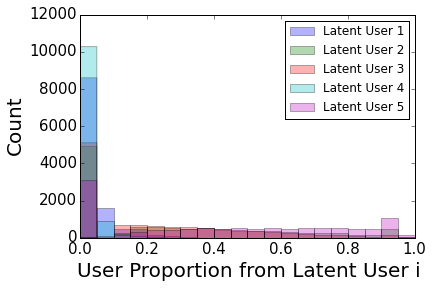

In [19]:
plt.figure()
for i in range(5):
    plt.hist(user_proportions_from_latent_users[:, i], alpha=0.3, label="Latent User " + str(i+1),
            range=(0,1), bins=20)
plt.xlabel("User Proportion from Latent User i", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

# Inspect the first latent user

Note the following description from https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

components_ : array, [n_components, n_features]
Variational parameters for topic word distribution. Since the complete conditional for topic word distribution is a Dirichlet, components_[i, j] can be viewed as pseudocount that represents the number of times word j was assigned to topic i. It can also be viewed as distribution over the words for each topic after normalization: model.components_ / model.components_.sum(axis=1)[:, np.newaxis].


(2624,)
Percentiles of feature pseudocounts for latent user 1:
[  0.20000371   0.20000864   0.20001066   0.20001206   0.20001371
   0.20001527   0.20001703   0.20001851   0.2000214    0.20002363
   0.20002524   0.20002639   0.20002748   0.2000293    0.20003038
   0.2000319    0.20003355   0.20003511   0.20003661   0.20003786
   0.20003925   0.20004036   0.20004156   0.20004263   0.20004421
   0.20004549   0.20004712   0.20004849   0.20004945   0.20005038
   0.20005164   0.20005239   0.20005345   0.20005469   0.20005615
   0.20005724   0.20005921   0.20006122   0.20006249   0.20006399
   0.20006586   0.20006706   0.20006846   0.20007017   0.20007219
   0.20007455   0.20007678   0.2000793    0.20008212   0.20008585
   0.20008784   0.20009237   0.20009633   0.20010057   0.20010988
   0.20012238   0.20020791   0.20059602   0.20103288   0.20125019
   0.20156973   0.20179544   0.20207295   0.20233834   0.20252049
   0.20283061   0.20302641   0.20334742   0.20372083   0.20394038
   0.20436432

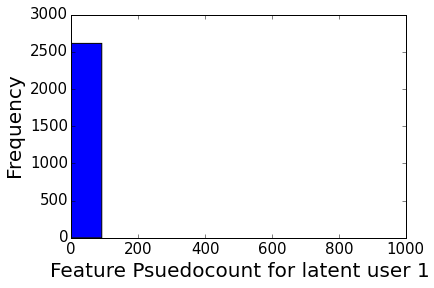

In [20]:
# lu1 is the vector of "pseudocounts": number of times a feature would be yes for latent user 1.

lu1 = latent_users[0, :]
print lu1.shape

print "Percentiles of feature pseudocounts for latent user 1:"
print np.percentile(lu1, np.arange(0,100,1))

plt.figure()
plt.hist(lu1)
plt.xlabel("Feature Psuedocount for latent user 1", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()



# What is latent user 1 like?


In [21]:
lu1_indices = np.where(lu1 > np.percentile(lu1, 99))[0]

#lu1_indices = np.array(sorted(lu1_indices, key= lambda x: lu1[x], reverse=True))


top_lu1_df = pd.DataFrame({'Feature': profile_categorical_df.columns.values[lu1_indices],
                         'Latent User 1 Pseudocount': lu1[lu1_indices]})

top_lu1_df.sort_values('Latent User 1 Pseudocount', inplace=True, ascending=False)

top_lu1_df.head(n=10)

,Feature,Latent User 1 Pseudocount
11,ethnicity_asian,913.449728
22,sign_gemini but it doesn&rsquo;t matter,352.299501
20,sign_aquarius but it doesn&rsquo;t matter,298.692853
17,religion_christianity and somewhat serious abo...,279.676430
18,religion_other and somewhat serious about it,243.113370
23,sign_scorpio but it doesn&rsquo;t matter,242.412818
8,education_graduated from ph.d program,220.388090
10,education_working on ph.d program,184.717966
3,diet_strictly vegetarian,174.491424
13,job_science / tech / engineering,169.692826


So which users are very much like this latent user 1?

(11504,)
Percentiles of user proportions from latent user 1:
[ 0.01176654  0.01177913  0.01178284  0.01178469  0.0117866   0.01178857
  0.01179051  0.01179291  0.01179598  0.0117996   0.01180549  0.01181457
  0.01183788  0.01187221  0.01250667  0.0125142   0.01251671  0.01251921
  0.01252079  0.01252202  0.01252361  0.01252502  0.01252631  0.01252775
  0.01252969  0.01253147  0.01253422  0.012537    0.01254142  0.01254772
  0.01255567  0.01257367  0.01260342  0.0126469   0.01334368  0.01334982
  0.01335236  0.01335474  0.01335644  0.01335771  0.01335952  0.01336145
  0.01336303  0.01336458  0.01336663  0.01336975  0.0133733   0.01337928
  0.01338709  0.01340047  0.01343836  0.01348652  0.01429543  0.01430496
  0.01430833  0.01431163  0.01431349  0.01431638  0.01431982  0.01432316
  0.01433036  0.01434449  0.01437307  0.01444725  0.01540022  0.0154093
  0.01541559  0.01542135  0.01543091  0.01547353  0.01667788  0.01670215
  0.01671815  0.01821014  0.01905484  0.06075188  0.07382338  0.

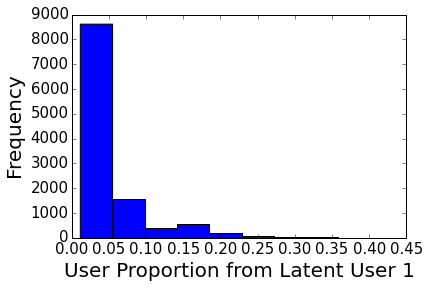

In [22]:
up1 = user_proportions_from_latent_users[:, 0]
print up1.shape


print "Percentiles of user proportions from latent user 1:"
print np.percentile(up1, np.arange(0,100,1))


plt.figure()
plt.hist(up1)
plt.xlabel("User Proportion from Latent User 1", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()


what users are highest in component 1?

In [23]:
tmp_profile_df = profile_df.copy()

tmp_profile_df.insert(0, "User Proportion from Latent User 1", up1)

tmp_profile_df.sort_values('User Proportion from Latent User 1', inplace=True, ascending=False)

tmp_profile_df.head()

,User Proportion from Latent User 1,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
24369,0.445271,28,thin,mostly anything,rarely,never,working on ph.d program,i'm thinking every waking minute of every day ...,currently i'm biding my time working on a doct...,i have an easy time remember stories i've hear...,NaN,"books: the silmarillion, i robot, the art of w...","sushi, matlab, movie theaters, close friends a...",stories i've read and stories i want to write....,NaN,NaN,"you love watching movies, you like taking pict...",asian,71.0,20000,student,2012-06-20-22-51,"berkeley, california",NaN,straight,NaN,NaN,m,NaN,no,"english (fluently), indonesian (poorly)",single
42079,0.422770,26,fit,other,rarely,never,working on ph.d program,i was born in michigan and moved out to the ba...,working on a phd!,"playing popular tunes on the piano, climbing u...",i'm tall for an asian...,"book: ender's game<br />\nfood: thai, korean, ...",internet<br />\niphone<br />\nwater bottle<br ...,...the next song to figure out how to play on ...,rockclimbing? watching a movie? building a tel...,i watch glee....,any or all of the following sound fun to you:<...,asian,72.0,20000,student,2012-06-25-00-24,"berkeley, california",NaN,straight,NaN,NaN,m,NaN,no,"english (fluently), korean (okay), spanish (po...",single
57193,0.396510,30,average,NaN,socially,sometimes,graduated from ph.d program,"chinese-american guy, born in ca, spent a few ...","out east now, just graduated, the big '04... i...",ummm... chemistry? and making analogies to thi...,NaN,"eternal sunshine of the spotless mind, the oc,...","cell fone, mtv, rice, sleep, internet, and $$$$",NaN,"drinkin' somewhere, or just chillin'",NaN,NaN,asian,69.0,50000,science / tech / engineering,2012-06-26-22-26,"berkeley, california",NaN,straight,likes dogs and likes cats,christianity and somewhat serious about it,m,gemini but it doesn&rsquo;t matter,when drinking,"english (fluently), chinese (poorly), spanish ...",single
24261,0.382330,26,fit,NaN,socially,never,working on ph.d program,i spend most of my time reading science papers...,i'm a graduate student studying the intersecti...,anything nerdy except i have never played dung...,NaN,my favorite tv show is definitely the wire. pe...,internet access<br />\nmy road bike<br />\nbus...,NaN,usually in lab trying to not have to repeat so...,NaN,you want to talk about the wire or your favori...,asian,69.0,20000,student,2012-06-27-23-37,"berkeley, california",NaN,straight,NaN,other,m,NaN,no,"english (fluently), c++ (okay), chinese (poorly)",single
9303,0.368691,29,NaN,NaN,socially,never,working on ph.d program,i guess my claim to fame is that i'm the baby ...,"i've lived in <a class=""ilink"" href=\n""/intere...","i'm a good <a class=""ilink"" href=\n""/interests...","my eyes. they're greenish hazel, mostly, but t...","ok, i'm just gonna break this one up like they...","first and foremost, i could never give up my f...",the future. will i meet someone amazing? will ...,often i'll get together with some friends and ...,"i'm kinda a dork. i like to read, play video g...","you'd like to know more about me, or if you'd ...",white,71.0,20000,student,2012-01-25-20-32,"el cerrito, california",NaN,straight,likes dogs and likes cats,NaN,m,gemini but it doesn&rsquo;t matter,no,"english (fluently), japanese, spanish",seeing someone


# Getting the Feature distributions for latent User 1.

Analogous to the word distributions for a topic.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html



(2624,)
Percentiles of the feature proportions for latent user 1:
[  3.78403704e-05   3.78413032e-05   3.78416852e-05   3.78419493e-05
   3.78422627e-05   3.78425578e-05   3.78428912e-05   3.78431704e-05
   3.78437166e-05   3.78441401e-05   3.78444441e-05   3.78446610e-05
   3.78448677e-05   3.78452112e-05   3.78454156e-05   3.78457037e-05
   3.78460158e-05   3.78463119e-05   3.78465943e-05   3.78468317e-05
   3.78470945e-05   3.78473039e-05   3.78475320e-05   3.78477333e-05
   3.78480335e-05   3.78482757e-05   3.78485826e-05   3.78488421e-05
   3.78490249e-05   3.78491997e-05   3.78494377e-05   3.78495799e-05
   3.78497803e-05   3.78500156e-05   3.78502912e-05   3.78504980e-05
   3.78508704e-05   3.78512521e-05   3.78514912e-05   3.78517758e-05
   3.78521285e-05   3.78523562e-05   3.78526211e-05   3.78529442e-05
   3.78533260e-05   3.78537739e-05   3.78541957e-05   3.78546712e-05
   3.78552063e-05   3.78559106e-05   3.78562873e-05   3.78571444e-05
   3.78578943e-05   3.78586954e-05   

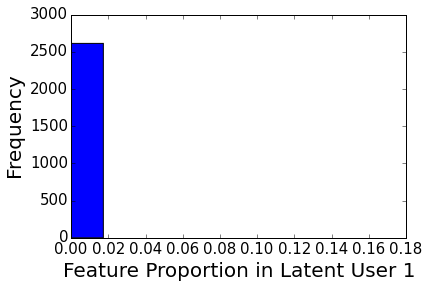

In [24]:
feature_distribution = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]


fd1 = feature_distribution[0, :]
print fd1.shape

print "Percentiles of the feature proportions for latent user 1:"
print np.percentile(fd1, np.arange(0,100,1))

plt.figure()
plt.hist(fd1)
plt.xlabel("Feature Proportion in Latent User 1", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.tick_params(labelsize=15)
plt.show()



# Log-likelihood on our data
You'll want to get this on a test set as well if you run this. If the test set is much much worse something is wrong.


In [26]:
print "Log-likelihood:"
print lda.score(profile_categorical_df.values)

print "Average log-likelihood per data point:" # makes more sense to compare this given different data sets
print lda.score(profile_categorical_df.values)/profile_categorical_df.shape[0]

Log-likelihood:
-783583.59082
Average log-likelihood per data point:
-68.1140117194


That's it for now.

Go have fun! And let us know how we can help!